In [150]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
import libpysal
from sklearn.model_selection import train_test_split, GridSearchCV
import os
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pickle
from sklearn.preprocessing import StandardScaler


In [151]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [152]:
rng = np.random.default_rng()

In [153]:
def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        df1 = pd.read_csv(path + filename)
        print(df1.shape, filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
        
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
#     df.plot(figsize = (40,40), column = "y")
#     plt.show()
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df 

In [168]:
# df15 = load_data(2015)
# df16 = load_data(2016)
df17 = load_data(2017)
df18 = load_data(2018)
df19 = load_data(2019)

(6204, 45) eindhoven17.csv_filled_.csv
(6247, 45) eindhoven18.csv_filled_.csv
(6174, 45) eindhoven19.csv_filled_.csv


In [155]:
# print((df15.y == 1).sum())
# print((df16.y == 1).sum())
print((df17.y == 1).sum())
print((df18.y == 1).sum())
print((df19.y == 1).sum())

499
478
527


In [156]:
X_train = df17[df17.columns[:-5]]
Y_train = df17.y
Y1_train = df17["y-1"]

X_val = df18[df18.columns[:-5]]
Y_val = df18.y
Y1_val = df18["y-1"]
# weights
wt = libpysal.weights.DistanceBand.from_dataframe(df17, threshold=150, binary = True, silence_warnings = True)
wv =libpysal.weights.DistanceBand.from_dataframe(df18, threshold=150, binary = True, silence_warnings = True)

In [157]:
X_test = df19[df19.columns[:-5]]
Y_test = df19.y
Y1_test = df19["y-1"]
# weights
wtest = libpysal.weights.DistanceBand.from_dataframe(df19, threshold=150, binary = True, silence_warnings = True)

In [158]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [159]:
oversamp = SMOTE()
x,y = oversamp.fit_resample(X_train, Y_train)

In [160]:
neighbors = [wtest.neighbors[x] for x in wtest.neighbors]  # ONly calculate Yt-1 val because at training it is just fitting the model
Y1_test = np.array([Y1_test[x].sum() for x in neighbors])
Y1_test[np.where(Y1_test == 0)[0]] = 0.5

In [161]:
param_hist = []
f1_hist = []
auc_hist = []
best_auc = 0


tm = LogisticRegression(random_state=0).fit(x, y)
         
preds = tm.predict_proba(X_val)[:,1]
preds = Y1_val * preds
auc = roc_auc_score(Y_val, preds)

if auc > best_auc:
    print(auc)
    best_auc = auc

p = np.zeros(len(preds))
pos = preds.argsort()[-(Y_val == 1).sum() :]
p[pos] = 1 
f1 = f1_score(Y_val, p)

f1_hist.append(f1)
auc_hist.append(auc)

            
best = np.argmax(auc_hist)
print("auc: {}, f1: {}".format(auc_hist[best], f1_hist[best]) )            

0.5679562747363451
auc: 0.5679562747363451, f1: 0.19456066945606695


# test:

In [162]:
preds = tm.predict_proba(X_test)[:,1]
preds = Y1_test * preds
auc = roc_auc_score(Y_test, preds)

In [163]:
p = np.zeros(len(preds))
pos = preds.argsort()[-(Y_test == 1).sum() :]
p[pos] = 1 
f1 = f1_score(Y_test, p)

In [166]:
with open ("../Results/Eindhoven.csv", "a+") as f:
    f.write("\nLR,{},{}".format(auc,f1))

In [167]:
print(auc, f1)

0.6689757184970677 0.1954459203036053


In [89]:
preds

array([0.01568017, 0.01936931, 0.04168992, ..., 0.17781797, 0.15096969,
       0.15045422])

In [19]:
with open ("../Results/modellen.csv", "a+") as f:
    f.write("DH,RF," + str(param_hist[np.argmax(auc_hist)]))

In [20]:
import pickle
f = open('../results/DHRFpreds','wb')
pickle.dump(preds,f)
f.close()

In [72]:
df19["preds"] = preds
df19["predicted"] = 0

In [38]:
with open ("../Results/Denhaagf1.csv", "a+") as f:
    f.write("model,1,2,3\n")
    f.write("MLP_Clust,{},{},{}".format(0.18181818181818182,0.4165781083953241, 0.295131845841785))

In [73]:
def checker(d):
    if d["y"] == 0 and d["preds"] == 0:
        return 0
    if d["y"] == 0 and d["preds"] == 1:
        return 1
    if d["y"] == 1 and d["preds"] == 0:
        return 2
    if d["y"] == 1 and d["preds"] == 1:
        return 3
    
df19["checked"] = df19.apply(checker, axis =1)

In [74]:
df19 = gpd.GeoDataFrame(df19)
# df19.geometry = df19.geometry.apply(shapely.wkt.loads)
df19 = df19.set_geometry("geometry")

In [75]:
eindhoven = pd.read_csv("../Data/filled/2019/Tilburg19.csv_filled_.csv")

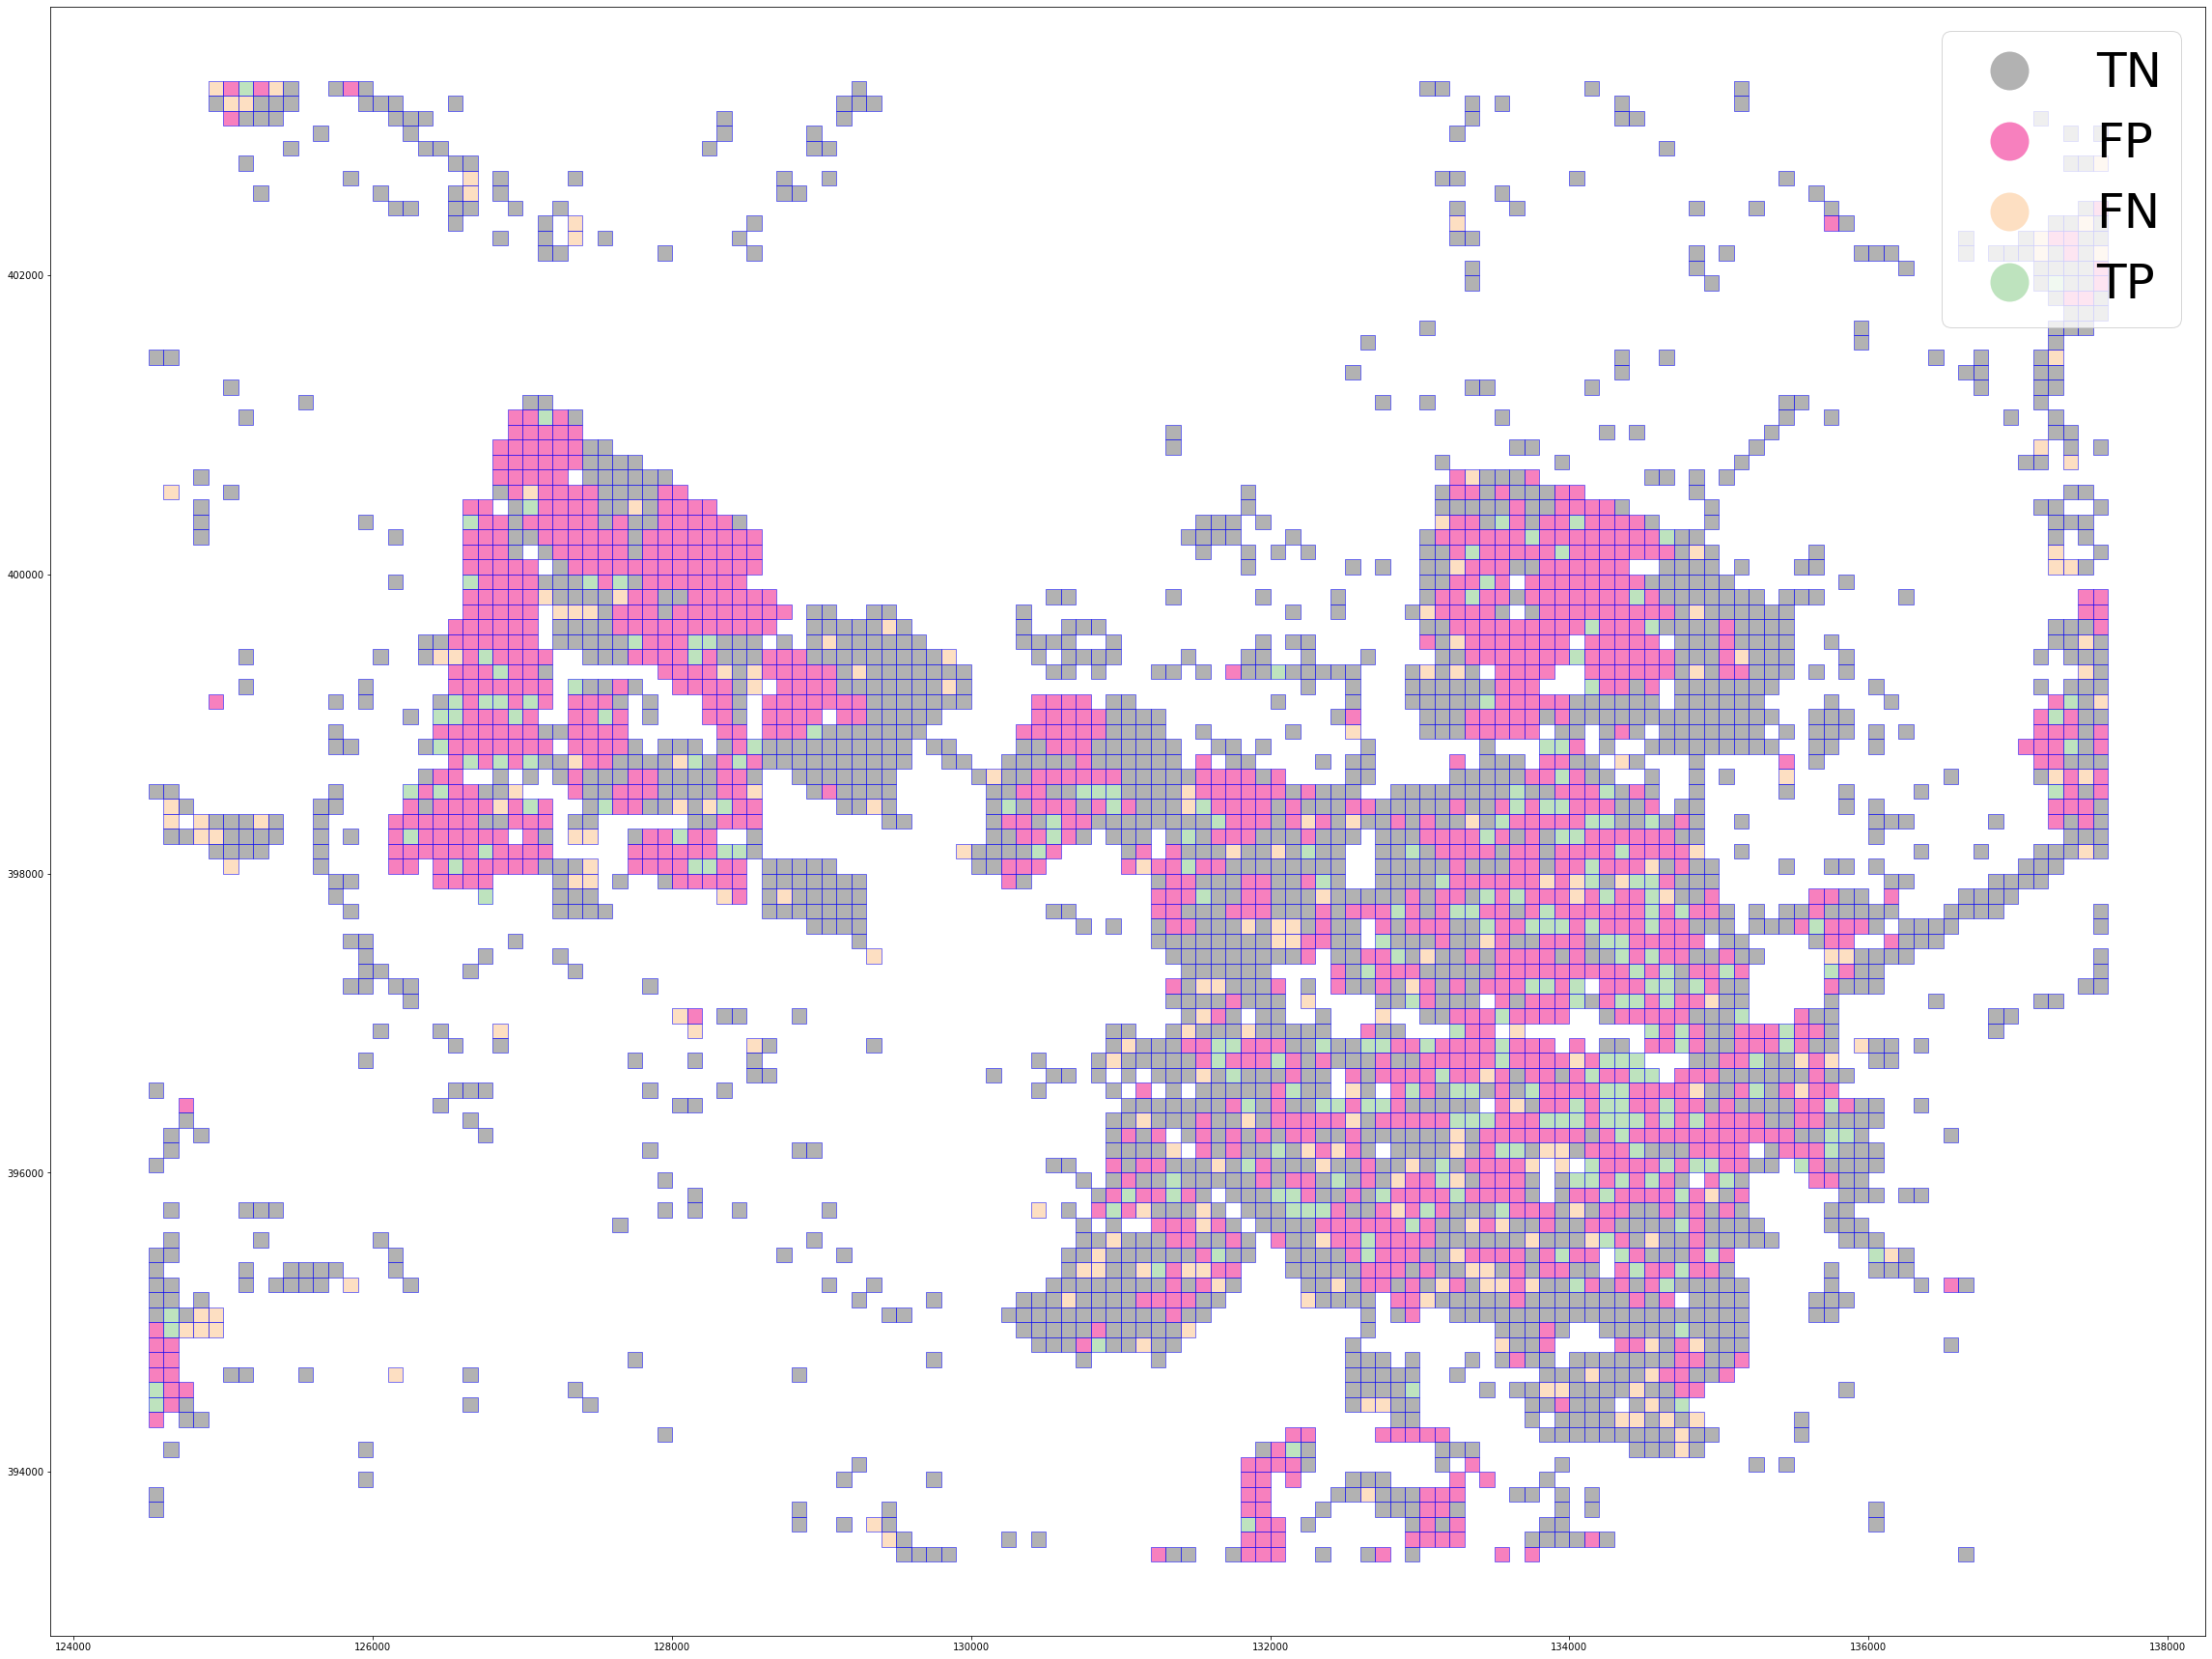

In [76]:
fig = plt.figure(figsize=(40, 40))
ax = plt.gca()
mapper = {0: "TN", 1: "FP", 2 : "FN", 3: "TP"}
df19[df19["C28992R100"].isin(eindhoven["C28992R100"])].plot(figsize = (40,40), cmap = "Accent_r", column = "checked", legend = True,
                                                           ax = ax, categorical=True, legend_kwds={'fontsize': 50, "markerscale":4},
                                                           alpha=0.5, edgecolor = "b")
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
                
legend = ax.get_legend()             
replace_legend_items(legend, mapper)
plt.show()

In [78]:
clf.best_params_

{'max_depth': 8, 'oob_score': True}

In [14]:
clf_bagger.best_params_

{'max_depth': 8, 'oob_score': False}

In [12]:
for i in df19.columns.values:
    print(i)

bijeenkomstfunctiesum
gezondheidszorgfunctiesum
industriefunctiesum
kantoorfunctiesum
logiesfunctiesum
onderwijsfunctiesum
sportfunctiesum
winkelfunctiesum
woonfunctiesum
oppervlakteVerblijfsobjectmean
inwoner_g
geboorte_g
inw_014_g
inw_1524_g
inw_2544_g
inw_4564_g
inw_65_g
p_western_g
p_nonWestern_g
p_buyhouses_g
p_rentals_g
p_socialHousing_g
medianIncome_g
avg_electricity_g
avg_gas_g
p_benefits_g
afs_haprak_g
afs_ziek_g
afs_superm_g
afs_vo_g
afs_oprit_g
afs_train_g
afs_transit_g
mean_WOZ
PLaagste40Inkomen
PHoogste20Inkomen
bouwjaarmean
bouwjaarmin
bouwjaarmax
y-1
C28992R100
geometry
y
BU_CODE
